In [1]:
import sys
import os

# Get the absolute path to the root directory where UQ_toolbox.py is located
root_dir = os.path.abspath(os.path.join(os.path.dirname('medMNIST'), '..'))
sys.path.append(root_dir)

In [2]:
import medmnist
from medmnist import INFO, Evaluator
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
from torchvision.models import resnet18
from sklearn.metrics import balanced_accuracy_score, confusion_matrix 
import seaborn as sns
import matplotlib.pyplot as plt
import UQ_toolbox as uq

In [3]:
# Define ResNet18 model
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.model = resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

In [4]:
# Load organAMNIST dataset
data_flag = 'organamnist'
download = True
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Repeat the single channel 3 times
])

test_dataset = DataClass(split='test', download=download, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [5]:
# Load the model
model_path = 'resnet18_organamnist.pt'
num_classes = len(info['label'])
model = ResNet18(num_classes=num_classes)
model.load_state_dict(torch.load(model_path))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Evaluate the model
model.eval()
y_true = []
y_score = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        y_true.extend(target.cpu().numpy().flatten())
        y_score.extend(output.cpu().numpy())

y_true = np.array(y_true)
y_score = np.array(y_score)

In [7]:
evaluator = Evaluator(data_flag, 'test')
auc, acc = evaluator.evaluate(y_score)
print(f'AUC: {auc:.3f}, Accuracy: {acc:.3f}')

AUC: 0.984, Accuracy: 0.870


In [8]:
# Calculate balanced accuracy
balanced_acc = balanced_accuracy_score(y_true, np.argmax(y_score, axis=1))
print(f'Balanced Accuracy: {balanced_acc:.3f}')

Balanced Accuracy: 0.866


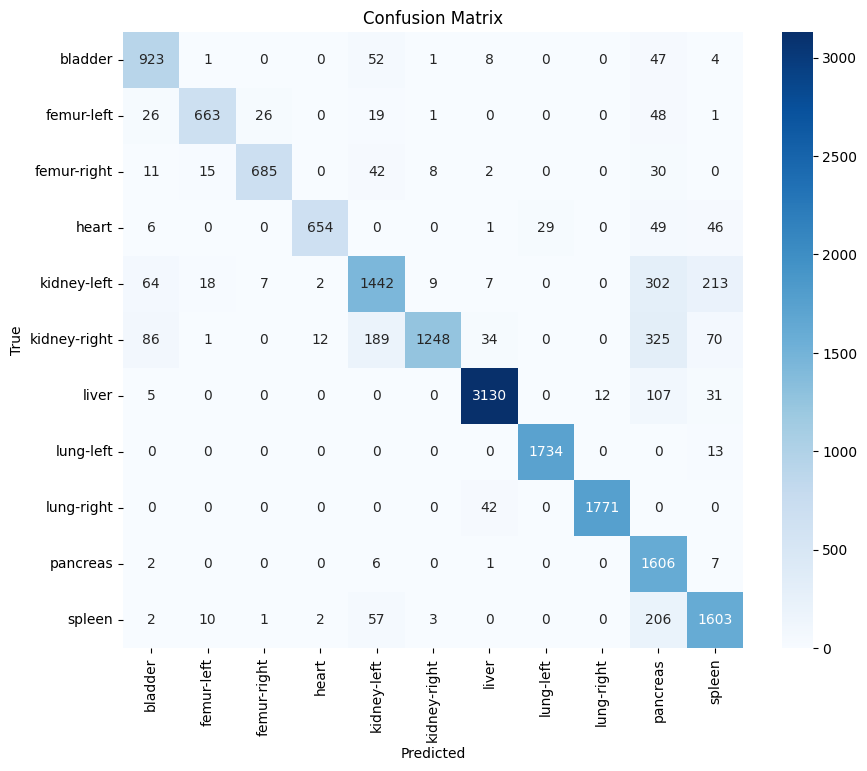

In [9]:
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_score.argmax(axis=1))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=info['label'].values(), yticklabels=info['label'].values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_608497/1194137215.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  ind.extend(np.array(F.softmax(torch.tensor(output.cpu().numpy()), dim=1)))


Ensemble AUC: 0.997, Ensemble Accuracy: 0.944


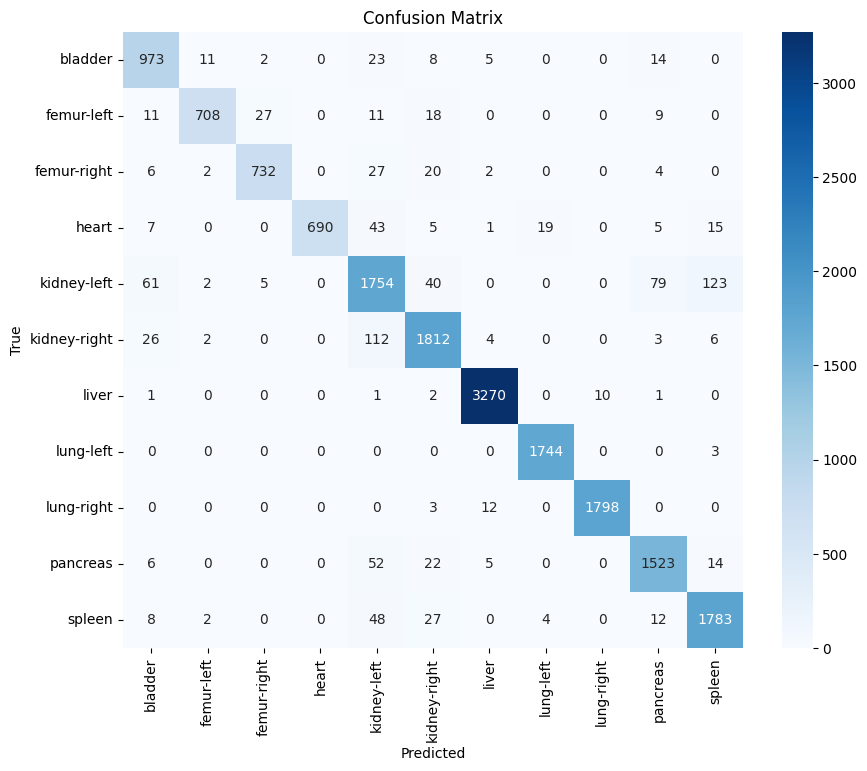

In [21]:
# Load saved models
models = []
for i in range(5):
    model = ResNet18(num_classes=num_classes)
    model.load_state_dict(torch.load(f'resnet18_organamnist{i}.pt'))
    model = model.to(device)
    model.eval()
    models.append(model)

# Perform inference on the test set
y_true = []
y_scores = []
indiv_scores = [[], [], [], [], []]

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = [model(data) for model in models]
        for ind, output in zip(indiv_scores, outputs):
            ind.extend(np.array(F.softmax(torch.tensor(output.cpu().numpy()), dim=1)))
            
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        y_true.extend(target.cpu().numpy().flatten())
        y_scores.extend(avg_output.cpu().numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Evaluate the ensemble model
evaluator = Evaluator(data_flag, 'test')
auc, acc = evaluator.evaluate(y_scores)
print(f'Ensemble AUC: {auc:.3f}, Ensemble Accuracy: {acc:.3f}')

# Generate the confusion matrix

cm = confusion_matrix(y_true, y_scores.argmax(axis=1))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=info['label'].values(), yticklabels=info['label'].values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [23]:
indiv_scores[0]

[array([3.0279174e-03, 5.0476426e-04, 4.4065810e-04, 1.0497251e-03,
        8.5328180e-01, 1.1735227e-03, 5.2674673e-04, 2.0627582e-03,
        1.2347517e-04, 1.3525768e-01, 2.5510180e-03], dtype=float32),
 array([9.9999177e-01, 4.7033279e-08, 2.1197941e-08, 7.3729405e-09,
        1.4944673e-06, 6.2099093e-06, 4.4844384e-08, 6.5948700e-09,
        1.5012903e-09, 3.8254984e-07, 9.7622006e-08], dtype=float32),
 array([1.0881150e-08, 1.0709123e-08, 2.2744326e-08, 3.4220342e-08,
        3.0466516e-08, 2.0415725e-06, 4.3203568e-06, 1.8446482e-06,
        9.9999166e-01, 1.9425765e-09, 1.2155970e-08], dtype=float32),
 array([2.4454502e-07, 1.2271257e-08, 3.4453421e-08, 1.1347684e-06,
        6.5143105e-08, 4.9470594e-07, 9.9999726e-01, 1.3074819e-07,
        3.1564437e-07, 2.4670172e-07, 2.3729925e-08], dtype=float32),
 array([1.0653335e-06, 1.6606037e-08, 1.3976494e-07, 3.7563396e-07,
        3.0519450e-06, 9.9999082e-01, 3.0944059e-06, 1.0181278e-08,
        4.1018717e-07, 2.0353218e-07, 8.

In [24]:
y_scores

array([[-2.39921   , -3.088781  , -3.343891  , ..., -5.050914  ,
         2.7929323 , -0.6901924 ],
       [ 8.517899  , -3.5448182 , -3.3340523 , ..., -4.7551003 ,
        -1.791803  , -0.8770577 ],
       [-3.373677  , -5.1158805 , -3.8218942 , ..., 11.562306  ,
        -5.693364  , -3.832599  ],
       ...,
       [-2.041147  , -2.8200126 , -2.8422108 , ..., -3.178632  ,
         0.06185209, -1.5462642 ],
       [-3.3092163 , -3.9461129 , -5.4803634 , ..., -7.7534394 ,
        11.329692  , -0.16038679],
       [-1.9923114 , -3.4063451 , -3.48085   , ..., -1.5601728 ,
        -3.4330392 ,  0.26973408]], dtype=float32)

In [25]:
y_prob = np.array(F.softmax(torch.tensor(y_scores), dim=1))

/tmp/ipykernel_608497/2939530776.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_prob = np.array(F.softmax(torch.tensor(y_scores), dim=1))


In [26]:
distances = uq.distance_to_hard_labels_computation(y_prob)

In [27]:
correct_predictions = [i for i in range(len(y_true)) if y_true[i] == np.argmax(y_scores[i])]
incorrect_predictions = [i for i in range(len(y_true)) if y_true[i] != np.argmax(y_scores[i])]

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:206: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


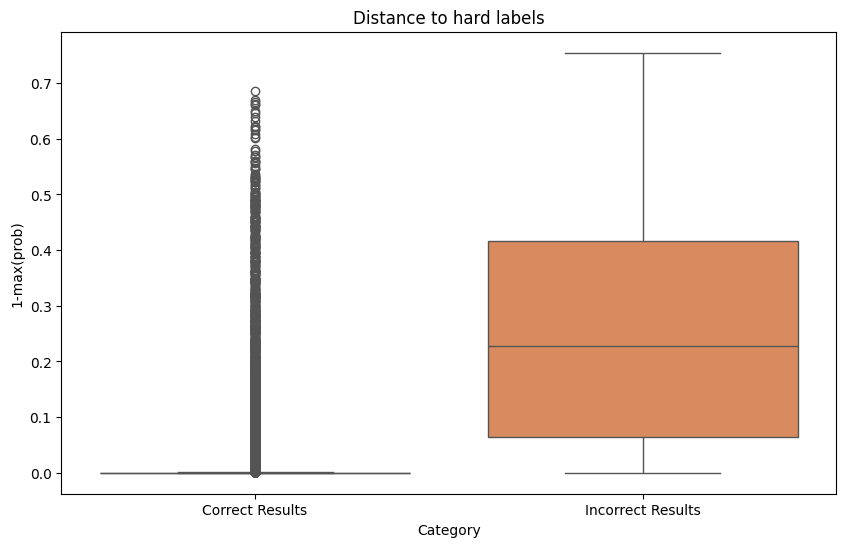

In [28]:
uq.UQ_method_plot([distances[k] for k in correct_predictions], [distances[j] for j in incorrect_predictions], '1-max(prob)', 'Distance to hard labels', swarmplot=False)

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:206: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


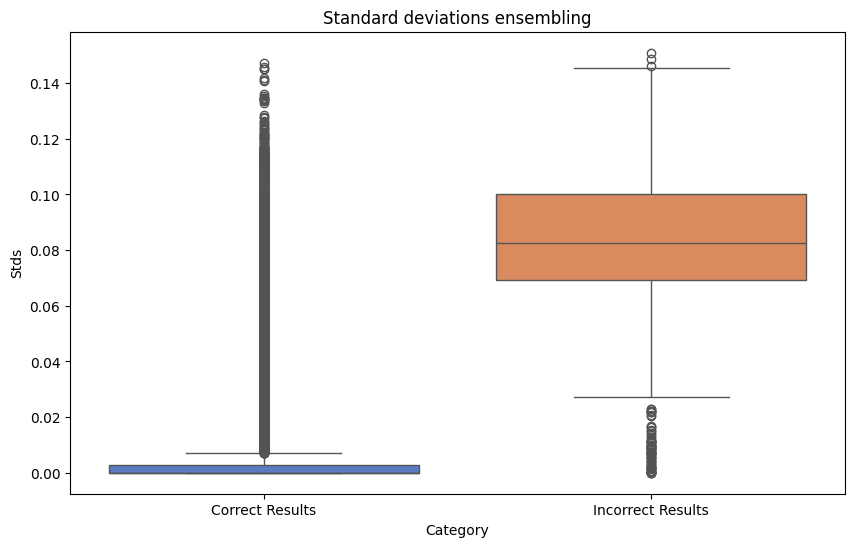

In [29]:
stds = uq.ensembling_stds_computation(indiv_scores)
uq.UQ_method_plot([stds[k] for k in correct_predictions], [stds[j] for j in incorrect_predictions], 'Stds', 'Standard deviations ensembling', swarmplot=False)

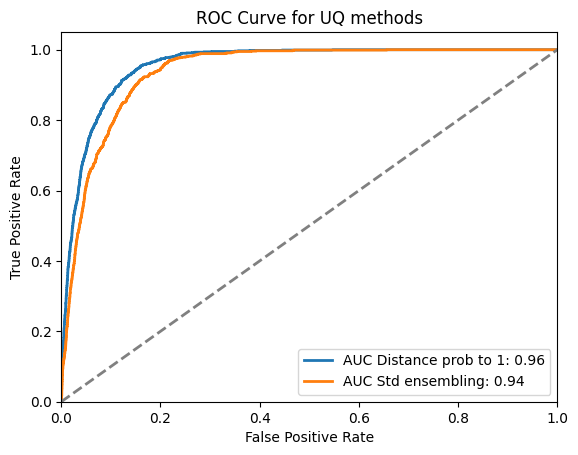

In [30]:
fpr_distance_to_hard_labels, tpr_distance_to_hard_labels, auc_distance_to_hard_labels = uq.roc_curve_UQ_method_computation([distances[k] for k in correct_predictions], [distances[j] for j in incorrect_predictions])
fpr_stds, tpr_stds, auc_stds = uq.roc_curve_UQ_method_computation([stds[k] for k in correct_predictions], [stds[j] for j in incorrect_predictions])
uq.roc_curve_UQ_methods_plot(['Distance prob to 1', 'Std ensembling'], [fpr_distance_to_hard_labels, fpr_stds], [tpr_distance_to_hard_labels, tpr_stds], [auc_distance_to_hard_labels, auc_stds])

In [31]:
mean_values = uq.standardize_and_mean_ensembling(np.column_stack((stds, distances)))

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:206: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


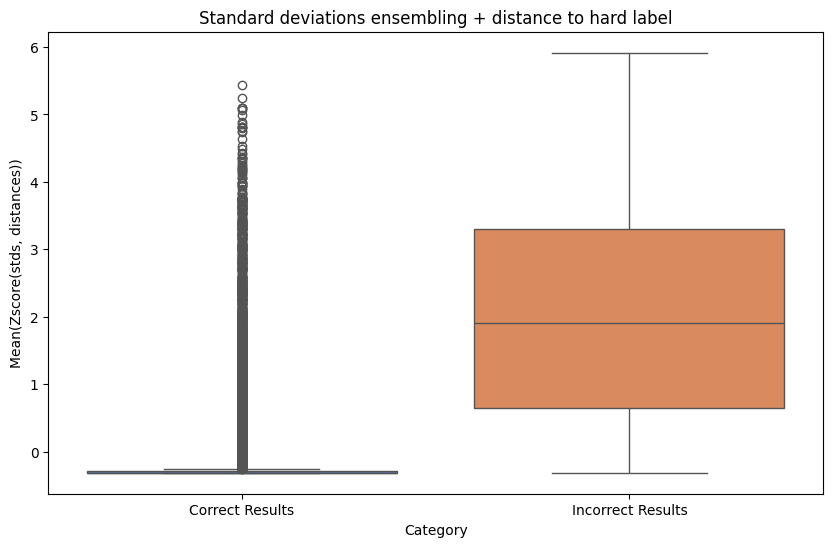

In [32]:
uq.UQ_method_plot([mean_values[k] for k in correct_predictions], [mean_values[j] for j in incorrect_predictions], 'Mean(Zscore(stds, distances))', 'Standard deviations ensembling + distance to hard label', swarmplot=False)

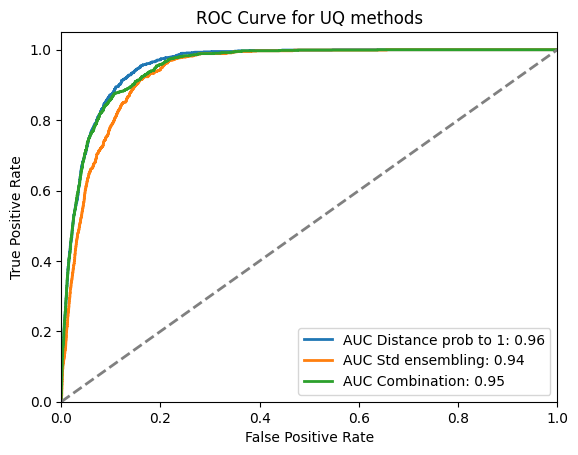

In [34]:
fpr_comb, tpr_comb, auc_comb = uq.roc_curve_UQ_method_computation([mean_values[k] for k in correct_predictions], [mean_values[j] for j in incorrect_predictions])
uq.roc_curve_UQ_methods_plot(['Distance prob to 1', 'Std ensembling', 'Combination'], [fpr_distance_to_hard_labels, fpr_stds, fpr_comb], [tpr_distance_to_hard_labels, tpr_stds, tpr_comb], [auc_distance_to_hard_labels, auc_stds, auc_comb])

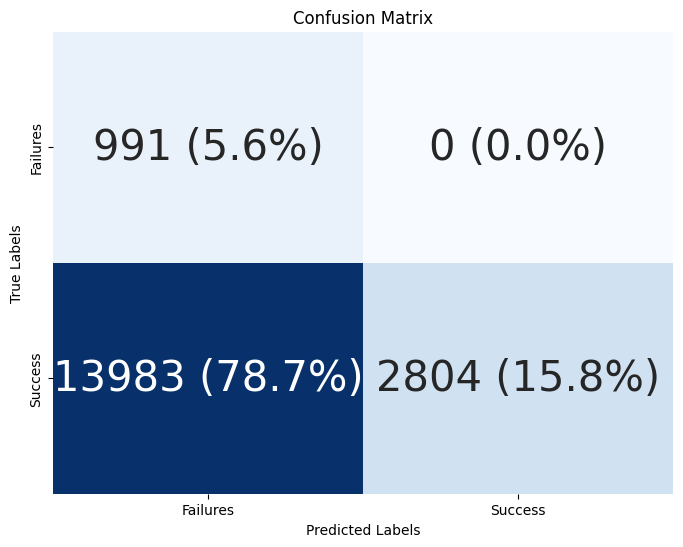

Threshold: 0.0
Specificity (TNR): 1.00
Sensitivity (TPR): 0.17
Balanced Accuracy: 0.58
True Negatives (TN): 991
False Positives (FP): 0
False Negatives (FN): 13983
True Positives (TP): 2804


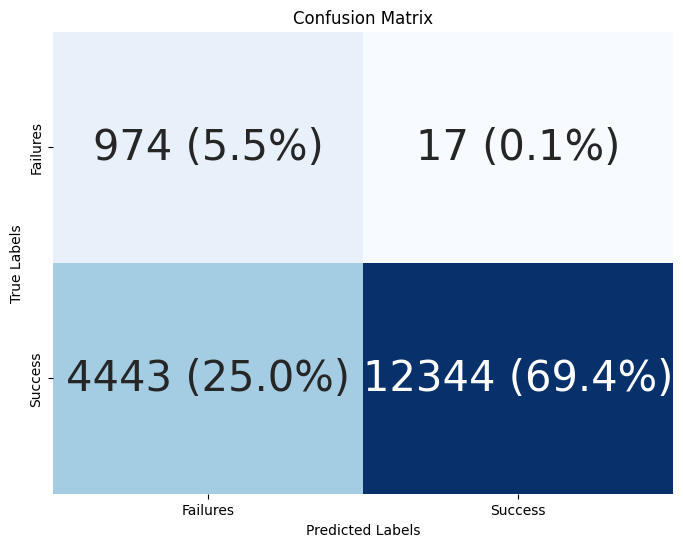

Threshold: 0.0019636843353509903
Specificity (TNR): 0.98
Sensitivity (TPR): 0.74
Balanced Accuracy: 0.86
True Negatives (TN): 974
False Positives (FP): 17
False Negatives (FN): 4443
True Positives (TP): 12344


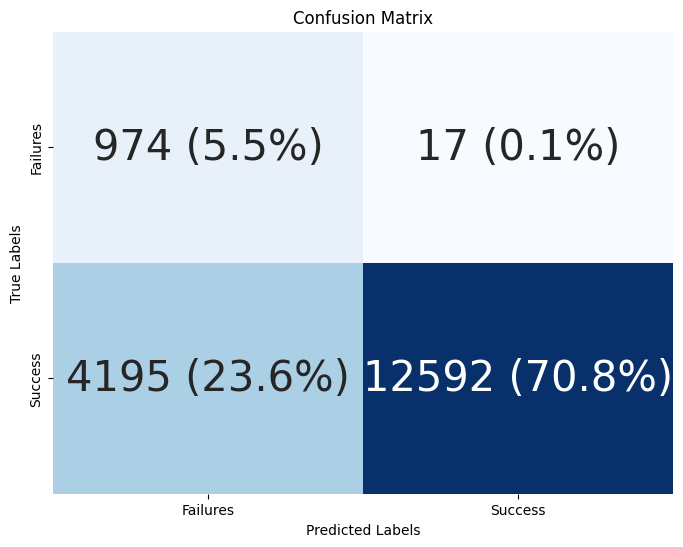

Threshold: -0.28842470049858093
Specificity (TNR): 0.98
Sensitivity (TPR): 0.75
Balanced Accuracy: 0.87
True Negatives (TN): 974
False Positives (FP): 17
False Negatives (FN): 4195
True Positives (TP): 12592
         Metric(s) TP (Count, Proportion) FP (Count, Proportion)
0       Dist to HL          2804 (15.77%)              0 (0.00%)
1              Std         12344 (69.43%)             17 (0.10%)
2  Dist to HL, Std         12592 (70.83%)             17 (0.10%)


In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import itertools

# Define the metrics
metrics = {
    "Dist to HL": distances,
    "Std": stds
}

# Define the labels
labels = np.array([1 if i in correct_predictions else 0 for i in range(len(mean_values))])

# Function to compute metrics
def compute_metrics(uq_values, labels, threshold):
    predictions = (uq_values <= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    balanced_acc = balanced_accuracy_score(labels, predictions)
    return tn, fp, fn, tp, specificity, sensitivity, balanced_acc

# Function to find the optimal threshold
def find_optimal_threshold(uq_values, labels, max_fp_rate=0.001):
    thresholds = np.linspace(min(uq_values), max(uq_values), 1000)
    best_threshold = thresholds[0]
    best_tp = 0
    total_cases = len(labels)
    max_fp = total_cases * max_fp_rate
    for threshold in thresholds:
        tn, fp, fn, tp, specificity, sensitivity, balanced_acc = compute_metrics(uq_values, labels, threshold)
        if fp <= max_fp and tp > best_tp:
            best_tp = tp
            best_threshold = threshold
    return best_threshold

# Function to summarize results
def summarize_results(uq_values, labels, threshold):
    tn, fp, fn, tp, specificity, sensitivity, balanced_acc = compute_metrics(uq_values, labels, threshold)
    total_cases = len(labels)
    tp_proportion = tp / total_cases
    fp_proportion = fp / total_cases
    return tp, tp_proportion, fp, fp_proportion

def display_confusion_matrix_success_flags_prop(cm):
    # Convert cm to a Pandas DataFrame
    df_cm = pd.DataFrame(cm, index=['Failures', 'Success'], columns=['Failures', 'Success'])

    # Convert to proportions (normalize by total sum)
    cm_proportions = (cm.astype(np.float64) / cm.sum()) * 100  # Convert to percentage
    cm_proportions = pd.DataFrame(cm_proportions, index=df_cm.index, columns=df_cm.columns)  # Convert to DataFrame

    # Initialize annotations with the same shape as df_cm
    annotations = df_cm.copy().astype(str)

    # Add percentage values to the confusion matrix
    for i in range(df_cm.shape[0]):
        for j in range(df_cm.shape[1]):
            annotations.iloc[i, j] = f"{df_cm.iloc[i, j]} ({cm_proportions.iloc[i, j]:.1f}%)"

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=annotations, fmt='', cmap='Blues', cbar=False, annot_kws={"size": 30})
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
# Define a function to display the confusion matrix and metrics
def display_results(uq_values, labels, threshold):
    tn, fp, fn, tp, specificity, sensitivity, balanced_acc = compute_metrics(uq_values, labels, threshold)
    cm = confusion_matrix(labels, (uq_values <= threshold).astype(int))
    display_confusion_matrix_success_flags_prop(cm)
    print(f"Threshold: {threshold}")
    print(f"Specificity (TNR): {specificity:.2f}")
    print(f"Sensitivity (TPR): {sensitivity:.2f}")
    print(f"Balanced Accuracy: {balanced_acc:.2f}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")

# Create a DataFrame to store the results
results = []

# Perform ablation study for each metric separately
for metric_name, uq_values in metrics.items():
    best_threshold = find_optimal_threshold(uq_values, labels)
    tp, tp_proportion, fp, fp_proportion = summarize_results(uq_values, labels, best_threshold)
    results.append([metric_name, f"{tp} ({tp_proportion:.2%})", f"{fp} ({fp_proportion:.2%})"])
    display_results(uq_values, labels, best_threshold)

# Perform ablation study for combinations of metrics
for r in range(2, len(metrics) + 1):
    for combination in itertools.combinations(metrics.keys(), r):
        combined_uq_values = uq.standardize_and_mean_ensembling(np.column_stack([metrics[key] for key in combination]))
        best_threshold = find_optimal_threshold(combined_uq_values, labels)
        tp, tp_proportion, fp, fp_proportion = summarize_results(combined_uq_values, labels, best_threshold)
        results.append([", ".join(combination), f"{tp} ({tp_proportion:.2%})", f"{fp} ({fp_proportion:.2%})"])
        display_results(combined_uq_values, labels, best_threshold)

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Metric(s)", "TP (Count, Proportion)", "FP (Count, Proportion)"])

# Display the results
print(results_df)